In [19]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from IPython.display import display, Image

In [20]:
model = ChatOpenAI(
    temperature=0,
    model="gpt-3.5-turbo")

In [21]:
class State(MessagesState):
    summary: str

In [22]:
def call_model(state: State):
    summary = state.get("summary" "")

    if summary:
        system_message = f"summary of the conversation: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}


In [23]:
def summarize_conversation(state: State):
    summary = state.get("summary" "")
    if summary:
        summary_message = (
            f"This is summary of the conversation so far: {summary}",
            "Extend the summary taking into consideration messages above:",
        )
    else:
        summary_message = "create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}
    

In [24]:
def should_continue(state: State):
    """ return the next state """
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END

In [25]:
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

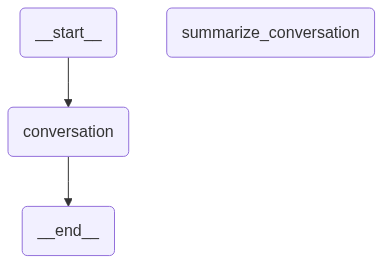

In [26]:
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": 1}}

In [28]:
# for chunk in graph.stream({"messages": [HumanMessage(content="Hi, I am mahadev")]}, config=config, stream_mode="update"):
#     print(chunk)
    

In [29]:
graph.invoke({"messages": [HumanMessage(content="Hi, I am mahadev")]}, config=config)

{'messages': [HumanMessage(content='Hi, I am mahadev', additional_kwargs={}, response_metadata={}, id='646ffb5a-64fb-4f0c-8174-b2a588d2688e'),
  AIMessage(content='Hello Mahadev, how can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 14, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BWeiX7r1zfoZc7HZzdgvlzb431MFY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--fee9e99e-9318-4ba9-a15b-be89e2feeedb-0', usage_metadata={'input_tokens': 14, 'output_tokens': 13, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [30]:
graph.get_state(config).values.get("summary")

In [32]:
graph.invoke({"messages": [HumanMessage(content="How is 49er doing")]}, config=config)

{'messages': [HumanMessage(content='Hi, I am mahadev', additional_kwargs={}, response_metadata={}, id='646ffb5a-64fb-4f0c-8174-b2a588d2688e'),
  AIMessage(content='Hello Mahadev, how can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 14, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BWeiX7r1zfoZc7HZzdgvlzb431MFY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--fee9e99e-9318-4ba9-a15b-be89e2feeedb-0', usage_metadata={'input_tokens': 14, 'output_tokens': 13, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='How